# **Predicting emissions using the _ARIMA_ model**

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

**Importing timeseries**

In [145]:
from aggregate import *

In [146]:
ts_dict = {'admin': ts_admin, 'centre_com': ts_centre_com, 'occup_cont': ts_occup_cont, 'autre': ts_autre}

**Plotting timeseries**

In [147]:
def show_trends(dict):
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for (i, j), key in zip([(0, 0), (0, 1), (1, 0), (1, 1)], dict.keys()):
        axs[i, j].plot(dict[key])
        axs[i, j].set_title(key)
        axs[i, j].set_ylabel('emission_ges')

    fig.suptitle(r'CO$_2$ emissions by category')
    plt.tight_layout()
    plt.show()

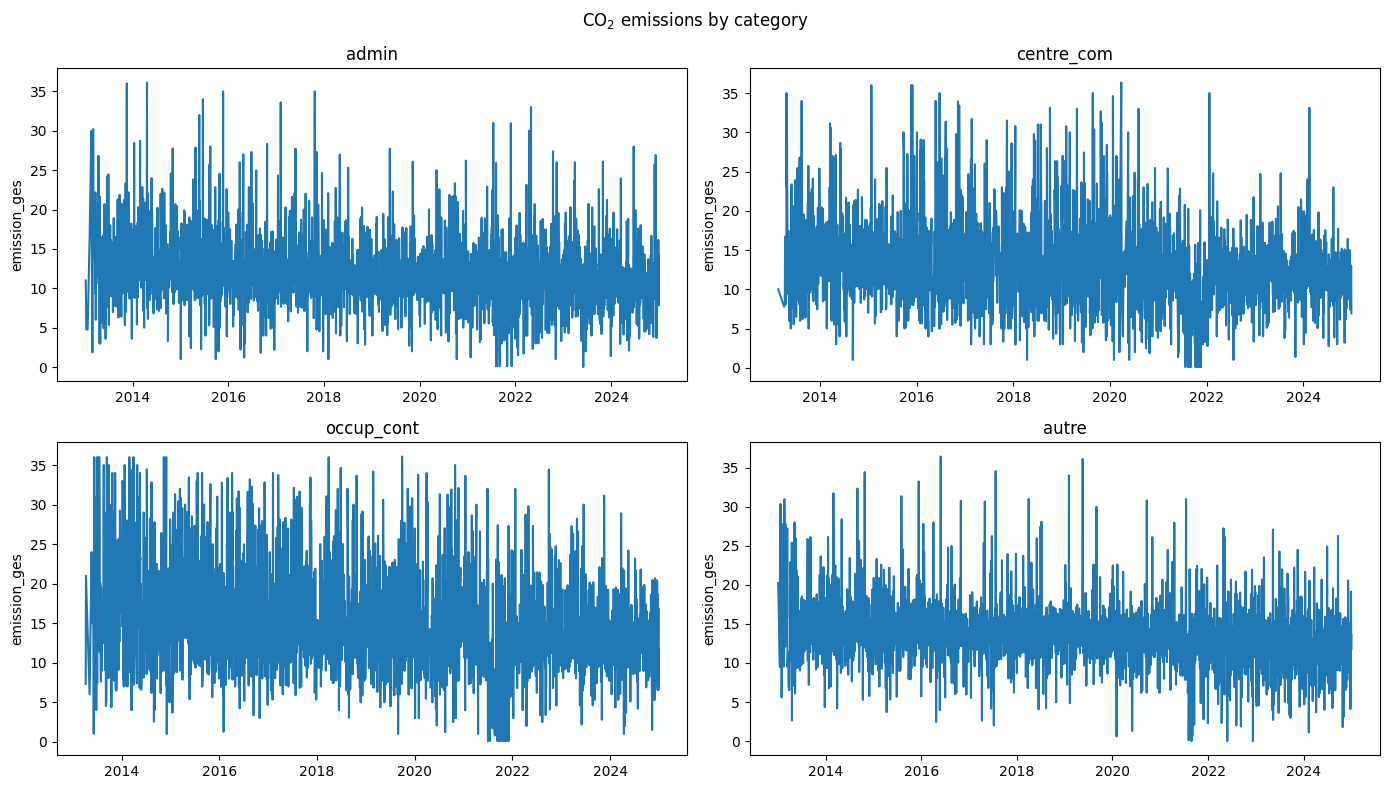

In [148]:
show_trends(ts_dict)

**Plotting differentiated timeseries**

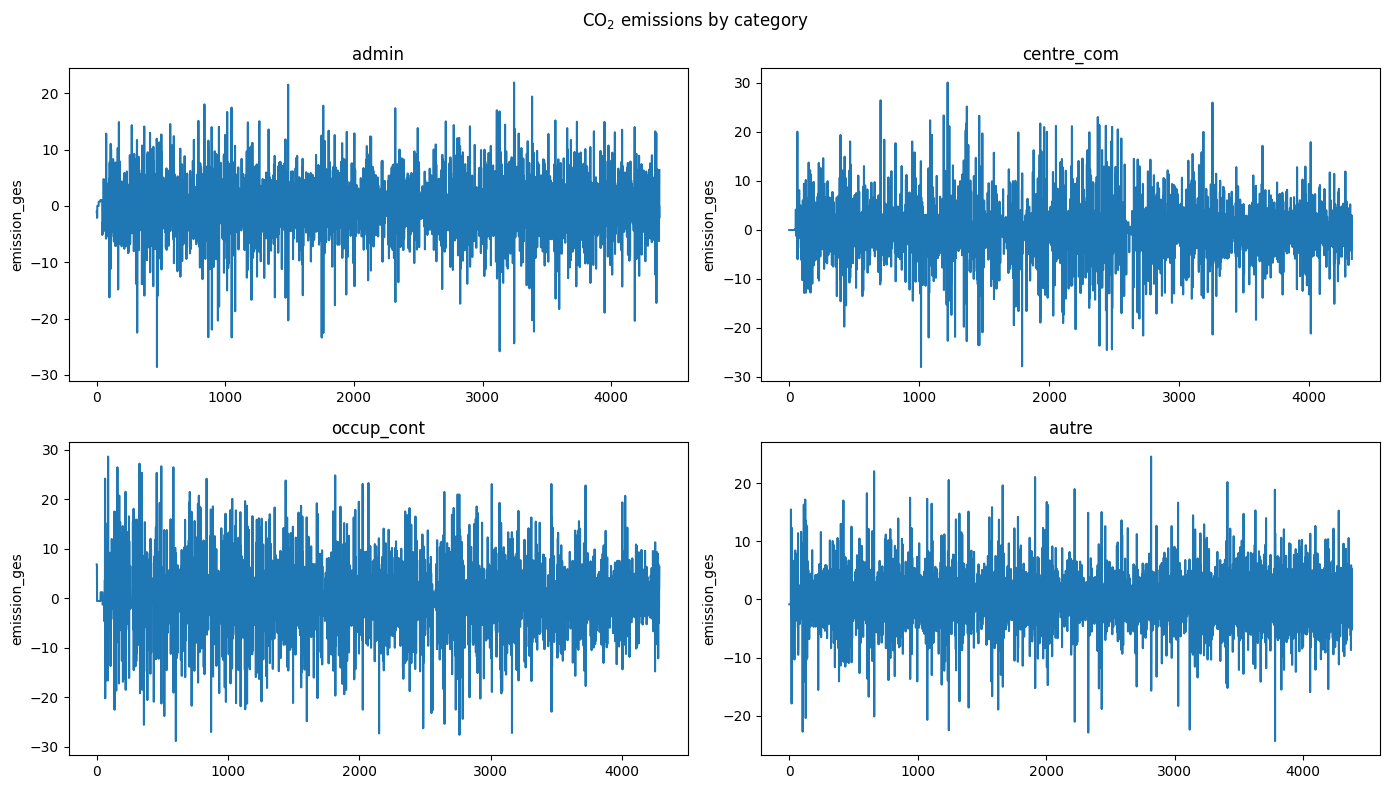

In [149]:
ts_diff_dict = dict(zip(ts_dict.keys(), list(map(np.diff, ts_dict.values()))))
show_trends(ts_diff_dict)

**Stationarity testing via the _Dickey-Fuller_ test**

In [150]:
for key, ts in ts_diff_dict.items():
    adf_result = adfuller(ts)
    print(f'----------------------------\n--> Column: §§ {key} §§')
    print(f'ADF Statistic:  {adf_result[0]}')
    print(f'p-value:  {adf_result[1]}')

----------------------------
--> Column: §§ admin §§
ADF Statistic:  -20.10094288274686
p-value:  0.0
----------------------------
--> Column: §§ centre_com §§
ADF Statistic:  -20.042481875121094
p-value:  0.0
----------------------------
--> Column: §§ occup_cont §§
ADF Statistic:  -20.790087023793628
p-value:  0.0
----------------------------
--> Column: §§ autre §§
ADF Statistic:  -19.80386662117319
p-value:  0.0


**Parameter estimation using the ACF and PCF**

In [151]:
def acf_pcf(ts, key:str):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plot_acf(ts, ax=plt.gca(), lags=40)
    plt.title(f'ACF of Differenced Series: {key}')
    plt.subplot(122)
    plot_pacf(ts, ax=plt.gca(), lags=40)
    plt.title(f'PACF of Differenced Series: {key}')
    plt.tight_layout()
    plt.show()

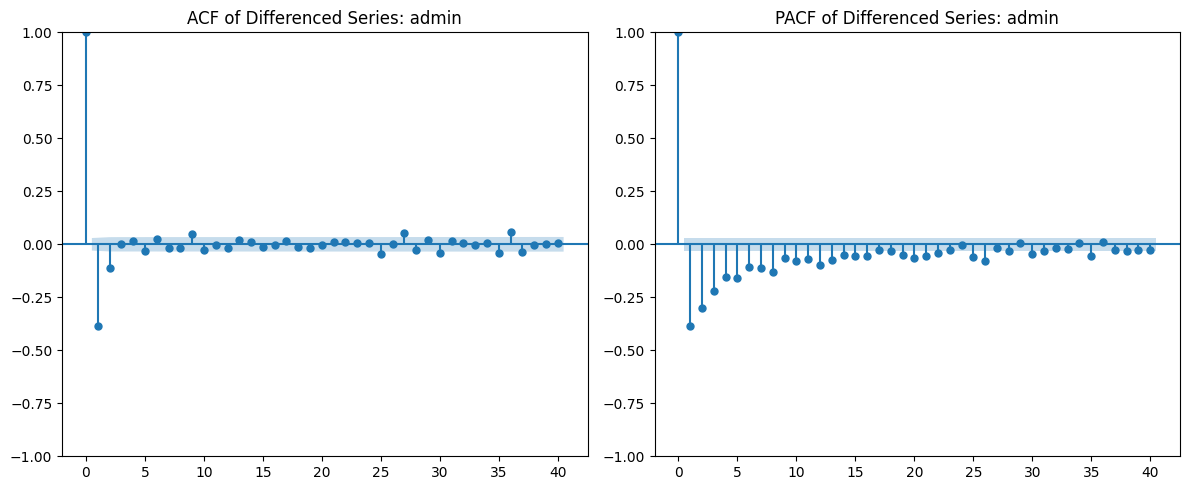

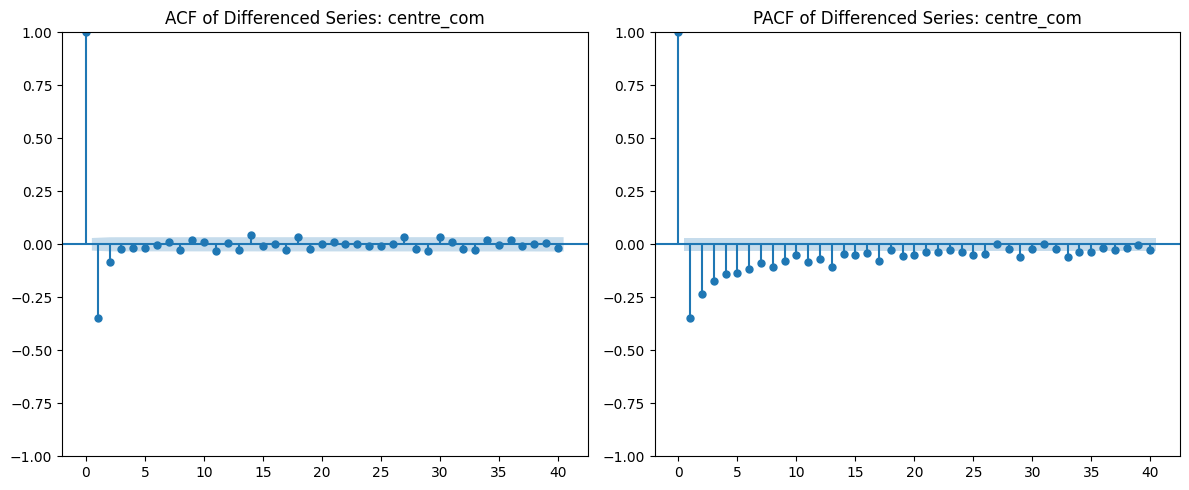

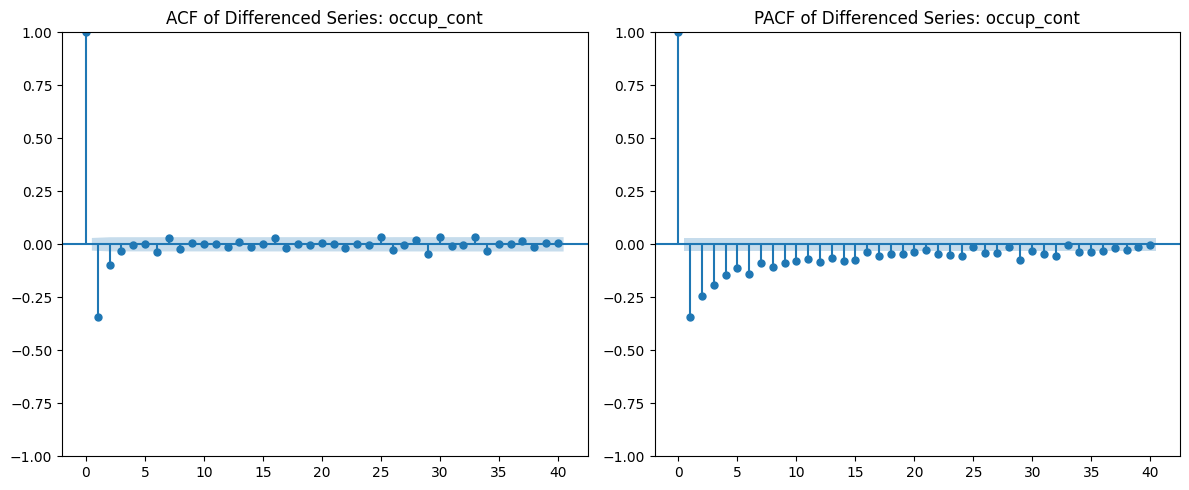

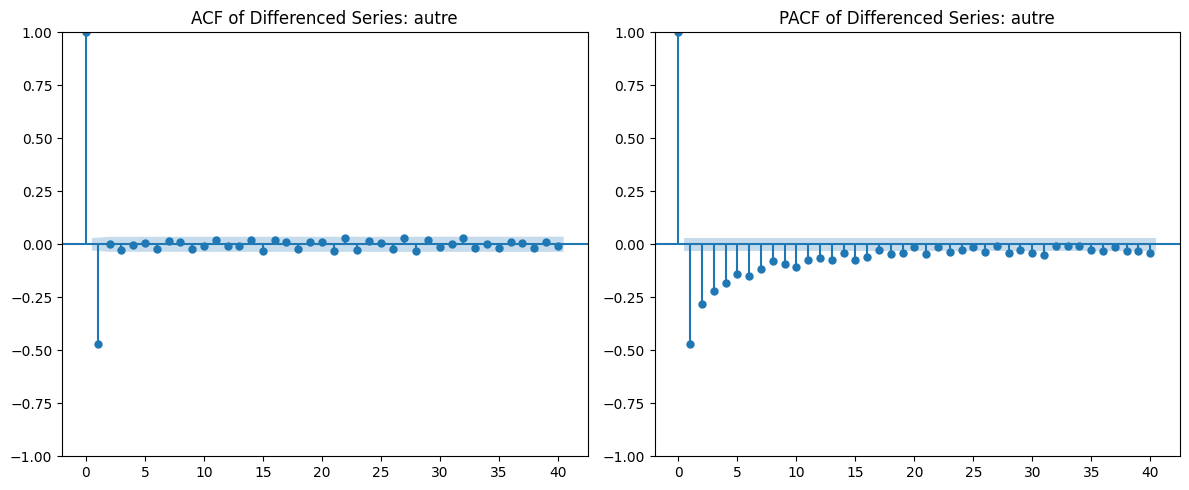

In [152]:
for key, ts in ts_diff_dict.items():
    acf_pcf(ts, key)

From the previous plots it seems that an _ARIMA(0, 1, 1)_ or _ARIMA(0, 1, 2)_ at most would be a great fit.

In [153]:
model_fits = {'admin':{(0, 1, 1): 0, (0, 1, 2): 0},  
              'centre_com': {(0, 1, 1): 0, (0, 1, 2): 0}, 
              'occup_cont': {(0, 1, 1): 0, (0, 1, 2): 0}, 
              'autre': {(0, 1, 1): 0, (0, 1, 2): 0}}

orders = [(0, 1, 1), (0, 1, 2)]
categs = list(ts_dict.keys())

for key, ts in ts_dict.items():
    for order in orders:
        model = ARIMA(ts, order=order)
        model_fit = model.fit()
        model_fits[key][order] = model_fit

In [154]:
columns = pd.MultiIndex.from_tuples([(cat, str(order)) for cat in categs for order in orders])

comparison_admin = pd.DataFrame(
    data=[[model_fits[cat][order].aic for cat in categs for order in orders], 
          [model_fits[cat][order].bic for cat in categs for order in orders]], 
    columns=columns, 
    index=['AIC', 'BIC']
    )

comparison_admin

admin                 centre_com                  occup_cont  \
        (0, 1, 1)     (0, 1, 2)    (0, 1, 1)     (0, 1, 2)     (0, 1, 1)   
AIC  23951.399778  23742.662287  25360.09483  25000.736306  26734.766483   
BIC  23964.167558  23761.813958  25372.84240  25019.857660  26747.491768   

                          autre                
        (0, 1, 2)     (0, 1, 1)     (0, 1, 2)  
AIC  26340.412982  22979.544540  22912.102853  
BIC  26359.500909  22992.314148  22931.257265

It seems like an _ARIMA(0, 1, 2)_ is a better fit.